<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [2]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [3]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/test.txt

--2022-02-04 07:18:10--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.04s   

2022-02-04 07:18:10 (30.7 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2022-02-04 07:18:10--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.

In [4]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [5]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [6]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [7]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [8]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words||
|Feature 1|This feature is to assign each word in the text to its character's length. It works because the postive reviews may use similar length of words in the text.| 0.777
|Feature 2|This feature might work because the positive reviews may contain more positive adjectives and the negative reviews may contain more negative adjectives.|0.572
|Feature 3|This feature counts the number of ! and ? in the text, because the positive reviews may contain more ! and the negative reviews may contain more ?.|0.590

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [11]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
      word=word.lower()
      feats[word] = 1           
    return feats

In [12]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 21224, Train accuracy: 1.000, Dev accuracy: 0.771


In [13]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)
    for word in words:
      word=word.lower()
      feats[word] = len(list(word))  
    return feats


In [14]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 21224, Train accuracy: 1.000, Dev accuracy: 0.777


In [15]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word in ['first-rate', 'good', 'awesome', 'incredible', 'positive', 'great', 'insightful', 
                    'clever', 'charming', 'comical', 'charismatic','uproarious'] :
            feats["contains_positive_word"] = 1
        if word in ["distasteful", "predictable", 'minus', 'atrocious', 'painful', 'boring', 'negative', 
                    'ordinary', 'disappointing', 'dreadful']:
            feats["contains_negative_word"] = 4
            
    return feats

In [16]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 2, Train accuracy: 0.579, Dev accuracy: 0.572


In [17]:

def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    feats = {}
    words = nltk.word_tokenize(text)
    feats["positive"] = words.count('!')
    feats["negative"] = words.count('?')
            
    return feats

In [18]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 2, Train accuracy: 0.587, Dev accuracy: 0.590


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [19]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [20]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 21226, Train accuracy: 1.000, Dev accuracy: 0.779


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


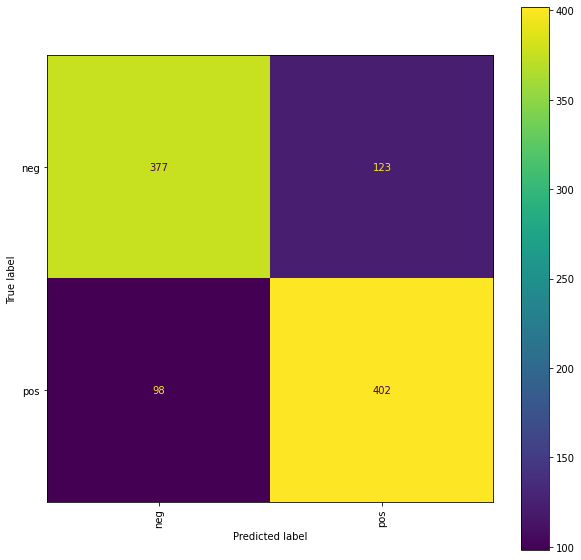

In [21]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [22]:
big_classifier.printWeights(n=25)

pos	0.280	great
pos	0.225	very
pos	0.214	enjoyed
pos	0.209	excellent
pos	0.184	amazing
pos	0.179	relationship
pos	0.170	simple
pos	0.170	fun
pos	0.165	performance
pos	0.160	incredible
pos	0.157	definitely
pos	0.145	wonderfully
pos	0.143	beautifully
pos	0.141	man
pos	0.140	fantastic
pos	0.139	series
pos	0.138	friends
pos	0.138	favorites
pos	0.137	takes
pos	0.132	perfect
pos	0.130	best
pos	0.128	gets
pos	0.128	you
pos	0.122	descriptions/summaries
pos	0.121	everyone

neg	-0.317	worst
neg	-0.258	would
neg	-0.258	stupid
neg	-0.243	even
neg	-0.226	acting
neg	-0.222	boring
neg	-0.202	horrible
neg	-0.194	there
neg	-0.181	waste
neg	-0.180	contains_negative_word
neg	-0.173	disappointment
neg	-0.162	killer
neg	-0.160	actors
neg	-0.149	instead
neg	-0.149	laughable
neg	-0.148	maybe
neg	-0.145	watching
neg	-0.144	nothing
neg	-0.144	attempt
neg	-0.143	idea
neg	-0.140	mystery
neg	-0.140	amateurish
neg	-0.139	poor
neg	-0.139	could
neg	-0.138	worse



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [23]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [24]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,1.000000,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1916,0.999991,neg,pos,"Having read the other comments on this film, I would like to share my own view that this is one tough movie to see unless you are a total Brooksophile. I am not.When looked at by a purely objective observer, the film is an unbalanced narrative that presents us with more undistilled neuroses than are capable of being absorbed in one sitting. It is quite difficult to watch. The Brooks character ..."
2,1178,0.999985,pos,neg,"While I do not think this was a perfect 10, I do agree it was way above a 6 which is what it's rated here. No, Brokedown Palace was not perfect and yes it's plot has been done many times before. That doesn't mean it shouldn't be done again if it is done well and I think this movie had some strong moments. The acting of Claire Danes, as already mentioned many times, was flawless as was Kate Bec..."
3,1784,0.999838,pos,neg,"The only complaint I have about this adaptation is that it is sexed-up. Things that were only hinted at in the novel are shown on-screen for some weird reason. Did they think the audience would be too stupid to understand if they were not shown everything out-right? Other than that, this is very good-quality. All the actors do marvelous jobs bringing their characters to life. For the shallow w..."
4,1608,0.999777,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling""is an everyday story of royal folk in late nineteenth century Austria.Set during one of Europe's seemingly incessant internal turmoils it concerns itself with the Emperor Franz Joseph (Mr James Mason),his rebellious son,the Crown Prince Rudolf (Mr Omar Sharif)the Empress(Miss Ava Gardner) and various mistresses,secret ..."
5,1659,0.999629,pos,neg,"Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly', one film moved me to want to actually see a change in international laws. The other felt like a poor attempt at making me cry fo..."
6,1783,0.999531,pos,neg,"Ira Levin's Deathtrap is one of those mystery films in the tradition of Sleuth that would be very easy to spoil given any real examination of the plot of the film. Therefore I will be brief in saying it concerns a play, one man who is a famous mystery playwright, another man who is a promising writer, the playwright's wife who is much younger and sexier than the role should have been, and one ..."
7,1726,0.999133,neg,pos,"I gave this movie a 2, and though I consider myself a science fiction fan, I found this movie very difficult to take seriously. It was on AMC one late night, and I'm glad I saw it for free. This movie is probably good for a few laughs, but not much more.The special effects are about average for the time period - not awful, but not great, either. Of course we know more about Mars now than we di..."
8,1960,0.998762,neg,pos,"One of the previous reviewers wrote that there appeared to be no middle ground for opinions of Love Story; one loved it or hated it. But there seems to be a remarkable distribution of opinions throughout the scale of 1 to 10. For me, this movie rated a 4. There are some beautiful scenes and locations, and Ray Milland turns in a fabulous job as Oliver's father. But the movie did not do a partic..."
9,1110,0.998695,neg,pos,"Before Stan Laurel became the smaller half of the all-time greatest comedy team